# Preprocessing

## Importing libraries

In [1]:
# Input and Output from Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get the data

In [2]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-1, 1, num_samples) # Input random
    # x = np.random.randint(-100, 100, num_samples) # Input random
    t = np.zeros(num_samples)
    
    t[0] = 0   # Inisialisasi
    
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0      0.388721  0.000000
1     -0.127019  0.851629
2      0.369568  0.710116
3      0.092851  0.577119
4     -0.746956  0.535556
...         ...       ...
29997  0.526740  0.957896
29998  0.097702  0.387899
29999 -0.548948  0.702666
30000 -0.319828  0.754188
30001 -0.590855  0.585665

[30002 rows x 2 columns]


In [5]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0  0.369568 -0.127019  0.388721  0.710116
1  0.092851  0.369568 -0.127019  0.577119
2 -0.746956  0.092851  0.369568  0.535556
3 -0.003352 -0.746956  0.092851  1.000358
4  0.465405 -0.003352 -0.746956  0.617178
(30000, 4)


In [6]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   # 100 sampel, input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

(30000, 3) (30000, 1)


In [7]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    assert len(X) == len(T), "Jumlah X dan T harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    # Train 15.000 pertama
    X_train = X[:15000]
    T_train = T[:15000]

    # Validation = 5000 terakhir train + 5000 setelah train
    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    # Test = 10000 terakhir
    X_test = X[20000:30000]
    T_test = T[20000:30000]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


# Neural Network Model

In [8]:
class NN:
    def __init__(self, input_size, hidden_size, output_size, lr=0.001, seed=42):
        np.random.seed(seed)

        # Parameters
        self.NI = input_size
        self.NH = hidden_size
        self.NO = output_size
        self.lr = lr

        # Weights
        self.v = np.random.rand(self.NI, self.NH)   # input x hidden
        self.vb = np.random.rand(self.NH)           # 1 x hidden
        self.w = np.random.rand(self.NH, self.NO)   # hidden x output
        self.wb = np.random.rand(self.NO)           # 1 x output

    # --- Activation functions ---
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    # Tanh Activation Function
    def tanh(self, x):
        return np.tanh(x)

    # Derivative of Tanh
    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    # --- Feedforward ---
    def feedforward(self, x):
        # hidden units
        self.z_in = np.dot(x, self.v) + self.vb
        self.z = self.sigmoid(self.z_in)                # change activation function here

        # output units
        self.y_in = np.dot(self.z, self.w) + self.wb
        #self.y = self.sigmoid(self.y_in)                # change activation function here! self.y is object in this class
        self.y = self.y_in                                                   

        return self.y

    # --- Backpropagation ---
    def backpropagation(self, x, t):
        # error output
        # delta_y = (t - self.y)*self.sigmoid_derivative(self.y_in)  # change activation function here
        delta_y = (t - self.y)                                   
        # del_w = self.lr * np.outer(self.z, delta_y)
        del_w = np.zeros_like(self.w)
        for k in range(self.NH):
            for j in range(self.NO):
                del_w[k][j] = self.lr * delta_y[j] * self.z[k]
        del_wb = self.lr * delta_y

        # error hidden
        delta_zin = np.dot(delta_y, self.w.T)
        delta_z = delta_zin * self.sigmoid_derivative(self.z_in)  # change activation function here
        # del_v = self.lr * np.outer(x, delta_z)
        del_v = np.zeros_like(self.v)
        for i in range(self.NI):
            for j in range(self.NH):
                del_v[i][j] = self.lr * delta_z[j] * x[i]
        del_vb = self.lr * delta_z

        # update bobot
        self.w += del_w
        self.wb += del_wb
        self.v += del_v
        self.vb += del_vb

        return np.mean(delta_y**2)   # return MSE

    # --- Training loop with validation for BPNN---
    def fit_bpnn(self, X_train, T_train, X_val=None, T_val=None,
            epochs=1000, tol=0.001, patience=20):
        history = {"train_loss": [], "val_loss": []}
        best_val_loss = float("inf")
        best_weights = None
        patience_ctr = 0             # ini untuk apa??

        for epoch in range(epochs):
            mse = 0
            # training
            for i in range(len(X_train)):
                x = X_train[i]
                t = T_train[i]
                self.feedforward(x)
                mse += self.backpropagation(x, t)
            mse /= len(X_train)
            history["train_loss"].append(mse)       # mse for every epoch

            # validation (no weight update)
            if X_val is not None and T_val is not None:
                val_loss = 0
                for i in range(len(X_val)):
                    x = X_val[i]
                    t = T_val[i]
                    y = self.feedforward(x)
                    val_loss += np.mean((t - y)**2)
                val_loss /= len(X_val)
                history["val_loss"].append(val_loss)

                # early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = (self.v.copy(), self.vb.copy(), self.w.copy(), self.wb.copy())
                    patience_ctr = 0  # reset patience counter
                else:
                    patience_ctr += 1
                
                # stop training if no improvement for 'patience' epochs
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}, val_loss={val_loss:.6f}, train_loss={mse:.6f}")
                    if best_weights is not None:
                        self.v, self.vb, self.w, self.wb = best_weights
                    break

            # tolerance check (on training loss)
            if mse < tol:
                print(f"Training stopped at epoch {epoch+1}, train_loss={mse:.6f}")
                if best_weights is not None:
                    self.v, self.vb, self.w, self.wb = best_weights
                break

        return history
    
    # --- Training loop with validation for NARX---
    def fit_narx(self, X_train, T_train, X_val=None, T_val=None,
            epochs=1000, tol=0.001, patience=20, y_lags=2):
        history = {"train_loss": [], "val_loss": []}
        best_val_loss = float("inf")
        best_weights = None
        patience_ctr = 0             # ini untuk apa??

        for epoch in range(epochs):
            mse = 0
            # buffer awal for y-lag
            y_buffer = [np.zeros(self.NO) for _ in range(y_lags)]
            # training
            for i in range(len(X_train)):
                x_only = X_train[i]
                x = np.concatenate([x_only] + y_buffer)  # [x(t), y(t-1), y(t-2)]
                t = T_train[i]
                self.feedforward(x)
                mse += self.backpropagation(x, t)
                # update buffer
                y_buffer = [self.y] + y_buffer[:-1]
            mse /= len(X_train)
            history["train_loss"].append(mse)       # mse for every epoch

            # validation (no weight update)
            if X_val is not None and T_val is not None:
                val_loss = 0
                y_buffer_val = [np.zeros(self.NO) for _ in range(y_lags)]
                for i in range(len(X_val)):
                    x_only = X_val[i]
                    x = np.concatenate([x_only] + y_buffer_val)
                    t = T_val[i]
                    y = self.feedforward(x)
                    val_loss += np.mean((t - y)**2)
                    y_buffer_val = [y] + y_buffer_val[:-1]
                val_loss /= len(X_val)
                history["val_loss"].append(val_loss)

                # early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = (self.v.copy(), self.vb.copy(), self.w.copy(), self.wb.copy())
                    patience_ctr = 0  # reset patience counter
                else:
                    patience_ctr += 1
                
                # stop training if no improvement for 'patience' epochs
                if patience_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}, val_loss={val_loss:.6f}, train_loss={mse:.6f}")
                    if best_weights is not None:
                        self.v, self.vb, self.w, self.wb = best_weights
                    break

            # tolerance check (on training loss)
            if mse < tol:
                print(f"Training stopped at epoch {epoch+1}, train_loss={mse:.6f}")
                if best_weights is not None:
                    self.v, self.vb, self.w, self.wb = best_weights
                break

        return history
    
    # --- Prediction ---
    def predict(self, X_test):
        outputs = []
        for x in X_test:
            outputs.append(self.feedforward(x))
        return np.array(outputs)
    
    # --- Prediction for NARX---
    def predict_narx(self, X_test, y_lags=2):
        outputs = []
        y_buffer = [np.zeros(self.NO) for _ in range(y_lags)]
        for x_only in X_test:
            x = np.concatenate([x_only] + y_buffer)
            y = self.feedforward(x)
            outputs.append(y)
            y_buffer = [y] + y_buffer[:-1]
        return np.array(outputs)


## First Block - NARX

In [ ]:
# buat model
y_lags = 2          # lags for feedback
model = NN(input_size=X_train.shape[1]+y_lags, hidden_size=128, output_size=1, lr=0.001)

# training
history = model.fit_narx(X_train, T_train, X_val, T_val, epochs=1000, tol=1e-3, patience=20, y_lags=y_lags)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

Training stopped at epoch 35, train_loss=0.000982
Last train loss: 0.0009822131051130663
Last val loss  : 0.0010274839836051305


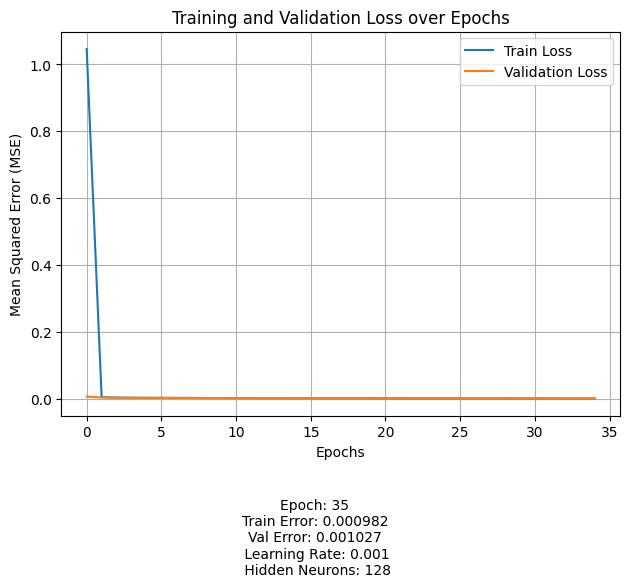

In [11]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}\n Learning Rate: {model.lr}\n Hidden Neurons: {model.NH}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [13]:
# testing
predictions = model.predict_narx(X_test)
mse_test = np.mean((T_test - predictions)**2)

print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)

Predictions: [0.17634408 0.44308419 0.99704372 ... 0.66506045 0.76357865 0.57247553]
Test MSE: 0.001038485176241441


In [16]:
print(predictions.shape)

(10000, 1)


In [25]:
print(predictions[:6])

[[ 0.17634408]
 [ 0.44308419]
 [ 0.99704372]
 [-0.08623065]
 [ 1.00320467]
 [ 0.94925144]]


## Second Block - BPNN

In [ ]:
# Generate dataset from prediction with 2 lags
def make_lagged_dataset(series, lags=2):
    X, T = [], []
    for t in range(lags+1, len(series)):
        X.append(series[t-lags-1:t])   # collect [y(t-2), y(t-1)]
        T.append(series[t])          # target y(t)
    return np.array(X), np.array(T)

# Split dataset perlu tidak??
X1, T1 = make_lagged_dataset(predictions.flatten(), lags=2)

# df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(f"X: {X1}")
print(f"T: {T1}")
print(X1.shape, T1.shape)

X: [[ 0.17634408  0.44308419  0.99704372]
 [ 0.44308419  0.99704372 -0.08623065]
 [ 0.99704372 -0.08623065  1.00320467]
 ...
 [ 0.57825863  0.94899499  0.38616326]
 [ 0.94899499  0.38616326  0.66506045]
 [ 0.38616326  0.66506045  0.76357865]]
T: [-0.08623065  1.00320467  0.94925144 ...  0.66506045  0.76357865
  0.57247553]
(9997, 3) (9997,)


In [ ]:
# buat model
model = NN(input_size=X_train.shape[1], hidden_size=128, output_size=1, lr=0.001)

# training
history = model.fit_narx(X_train, T_train, X_val, T_val, epochs=1000, tol=1e-3, patience=20, y_lags=y_lags)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])